# Выбор локации для скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

**Описание данных**

Признаки:
- *id — уникальный идентификатор скважины*
- *f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)*

Целевой признак:
- *product — объём запасов в скважине (тыс. баррелей).*

**Условия задачи:**
- *Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).*
- *При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.*
- *Бюджет на разработку скважин в регионе — 10 млрд рублей.*
- *При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.*
- *После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.*

**План работы:**
1. Загрузить и подготовить данные.
2. Обучить и проверить модель для каждого региона:
    - Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
    - Обучить модель и сделать предсказания на валидационной выборке.
    - Сохранить предсказания и правильные ответы на валидационной выборке.
    - Вывести на экран средний запас предсказанного сырья и RMSE модели.
    - Проанализировать результаты.
3. Подготовьться к расчёту прибыли:
    - Все ключевые значения для расчётов сохранить в отдельных переменных.
    - Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
    - Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
4. Посчитать риски и прибыль для каждого региона:
    - Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    - Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков.
5. Написать общий вывод

## Загрузка и подготовка данных

### Импорт необходимых библиотек и подготовка функций

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

ra_st = 271828      # random_state
state = np.random.RandomState(ra_st)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def my_read(name):                                        # Загрузка датасетов
    try:
        df_read = pd.read_csv('/datasets/' + name)
    except:
        df_read = pd.read_csv(r'C:\Users\Admiral\Desktop\учеба\практикум\Проекты\Datasets\07_' + name)
    return df_read


# Вывод необходимой информации по таблице
def my_info(df, n):
    print('\033[1m' + '\033[94m' + '='*40 + f'[.....РЕГИОН №{n}.....]' + '='*40 + '\033[0m')
    print(), print('\033[1m' + 'Первые 5 строк таблицы' + '\033[0m')
    display(df.head())
    print(), print('\033[1m' + 'Основные статистические показатели' + '\033[0m')
    display(df.describe())
    print(), print('\033[1m' + 'Общая информация по таблице' + '\033[0m')
    df.info()
    print(), print('\033[1m' + 'Гистограммы и боксплоты по признакам' + '\033[0m')
    my_hist_box(df, 'f0')
    my_hist_box(df, 'f1')
    my_hist_box(df, 'f2')
    my_hist_box(df, 'product')
    print(), print('\033[1m' + 'Проверка корреляции между признаками' + '\033[0m')
    my_corr(df)
    print(f'Количество дубликатов в таблице: {df.duplicated().sum()}')
    print(f'Количество дубликатов по скважинам: {df.id.duplicated().sum()}'), print()
    print('\033[1m' + 'Визуальная проверка дубликатов по столбцу "id"(первые 10 строк)' + '\033[0m')
    display(df[df.id.duplicated(keep=False) == True].sort_values('id').head(10)), print()
    print(f'Количество "пустых" скважин в регионе: {len(df[df["product"] == 0])}')
    print(f'Средний объем нефти в одной скважине: {df["product"].mean():.2f} тыс.баррелей')
    print('\n')

    
# Тепловая матрица корреляции    
def my_corr(df):
    plt.figure(figsize=(14, 5.7))
    sns.heatmap(df.corr(), annot=True, linewidths=.5)
    plt.title('Тепловая матрица корреляции', pad='20', fontsize=16)
    plt.show()

    
# Построение совместной гистограммы и боксплота для признаков
def my_hist_box(df, df_x):  
    sns.set(style='whitegrid')
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
    sns.boxplot(data=df, x=df_x, ax=ax_box)
    sns.distplot(df[df_x], ax=ax_hist)
    ax_box.set(xlabel='')
    ax_hist.set(xlabel='', ylabel='')
    plt.title('Проверка наличия аномальных значений и график распределения признака ' + df_x,\
              pad='75', fontsize=16)
    f.set_figheight(5)
    f.set_figwidth(12)
    plt.show()
    


# Обучение модели на основе алгоритма регрессии "Линейная регрессия" + вывод необходимых показателей
def my_LinReg(X, y, region):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=ra_st)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, predict)**0.5
    print('\033[1m' + '\033[94m' + '='*40 + f'[.....РЕГИОН №{region}.....]' + '='*40 + '\033[0m')
    print('Средний запас нефти в одной скважине по предсказанию модели:',\
          f'{predict.mean():.2f} тыс.баррелей')
    print(f'Средний фактический запас нефти в одной скважине : {y.mean():.2f} тыс.баррелей')
    print(f'RMSE на валидационной выборке: {rmse:.4f}')
    adequacy(y_valid, rmse)
    print()
    return model, predict, y_valid


# Проверка на адекватность модели путем сравнения rmse с rmse, полученным на сравнении
# фактических показателей с средним по фактическим показателям целевого признака
def adequacy(y_valid, rmse_pred):
    pred = pd.Series(y_valid.mean(), index=y_valid.index)
    rmse_adeq = mean_squared_error(y_valid, pred) ** 0.5
    print(f'Адекватность предсказаний модели: {1-rmse_pred/rmse_adeq:.1%}')
    


# Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def my_revenue(target, probabilities):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target.loc[probs_sorted.index].head(borehole_best)
    profit = selected.sum() * price_unit_product - total_budget
    return profit



# Функция с применением техники Bootstrap с 1000 выборок для нахождения распределение прибыли,
# вывода средней прибыли, 95%-го доверительного интервала и риска убытков для региона
def my_Bootstrap(t, p, n):
    values = []
    probabilitie = pd.Series(p, index=t.index)
    for i in range(1000):
        target_subsample = t.sample(borehole_count, replace=True, random_state=state)
        probs_subsample = probabilitie[target_subsample.index]
        values.append(my_revenue(target_subsample, probs_subsample))
    
    print('\033[1m' + '\033[94m' + '='*40 + f'[.....РЕГИОН №{n}.....]' + '='*40 + '\033[0m')
    print()
    values = pd.Series(values)
    plt.figure(figsize=(14, 4))
    sns.distplot(values)
    plt.xlabel('Прибыль, млрд.руб.')
    plt.title(f'Распределение прибыли в регионе №{n}', pad='20', fontsize=15)
    plt.show()
    
    print(), print(f'Средняя прибыль: {values.mean()/ 10**6:.2f} млн.рублей')
    down = values.quantile(0.025) / 10**6
    up = values.quantile(0.975) / 10**6
    print(f'95%-й доверительный интервал: от {down:.2f} до {up:.2f} млн.рублей')
    risk = len(values[values < 0]) / len(values)
    print(f'Риск убытков: {risk:.2%}'), print('\n')

### Изучение общей информации

In [3]:
data_0 = my_read('geo_data_0.csv')
data_1 = my_read('geo_data_1.csv')
data_2 = my_read('geo_data_2.csv')

Поочередно для каждого региона выведем необходимую информацию по признакам

========================================[.....РЕГИОН №0.....]========================================

Первые 5 строк таблицы


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Основные статистические показатели


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Гистограммы и боксплоты по признакам


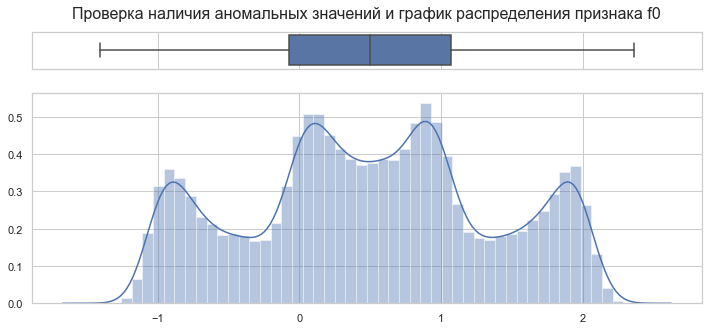

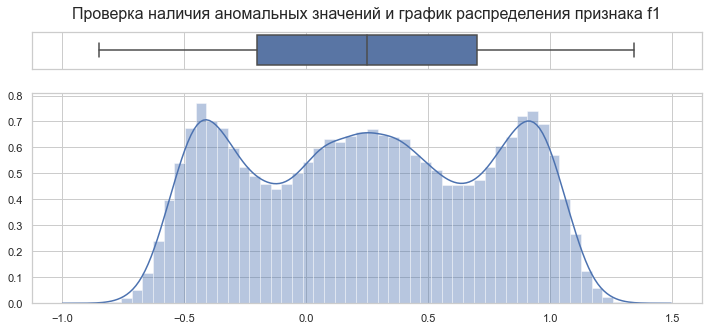

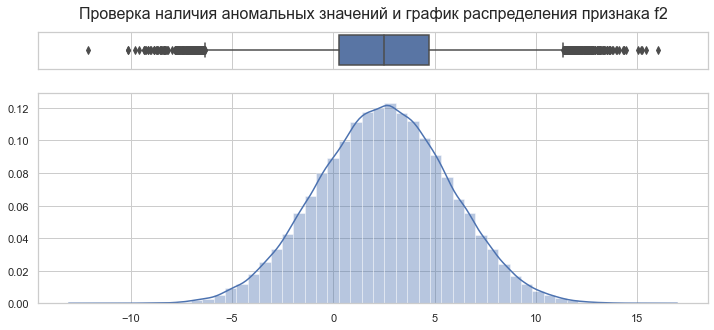

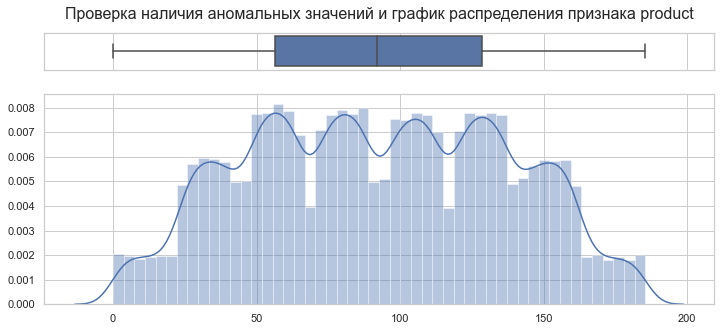


Проверка корреляции между признаками


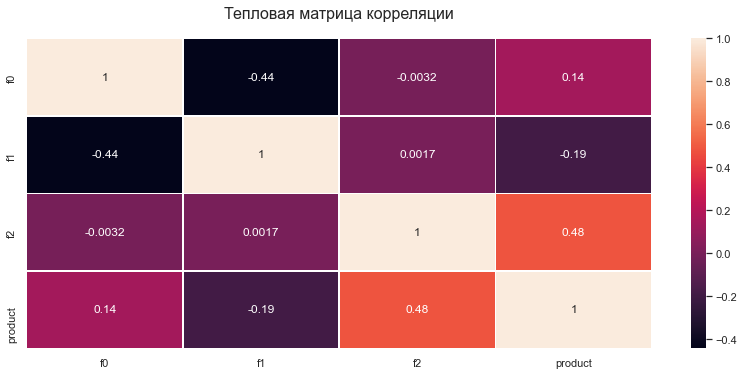

Количество дубликатов в таблице: 0
Количество дубликатов по скважинам: 10

Визуальная проверка дубликатов по столбцу "id"(первые 10 строк)


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502



Количество "пустых" скважин в регионе: 1
Средний объем нефти в одной скважине: 92.50 тыс.баррелей


========================================[.....РЕГИОН №1.....]========================================

Первые 5 строк таблицы


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Основные статистические показатели


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Гистограммы и боксплоты по признакам


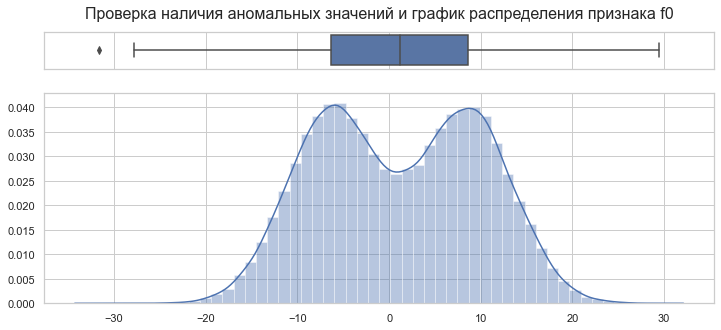

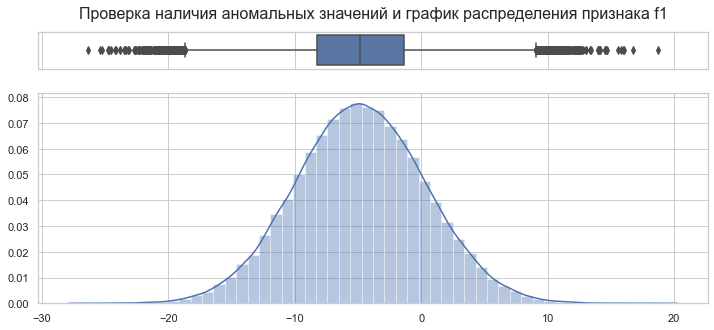

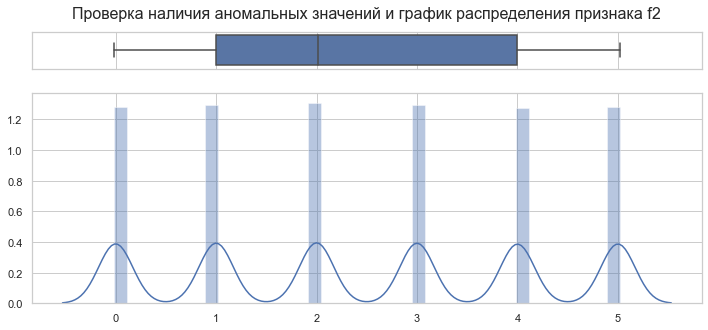

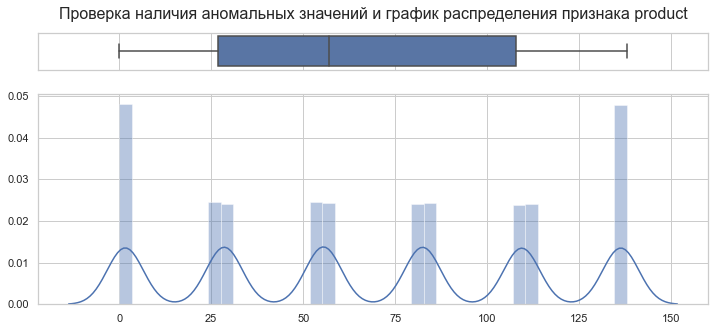


Проверка корреляции между признаками


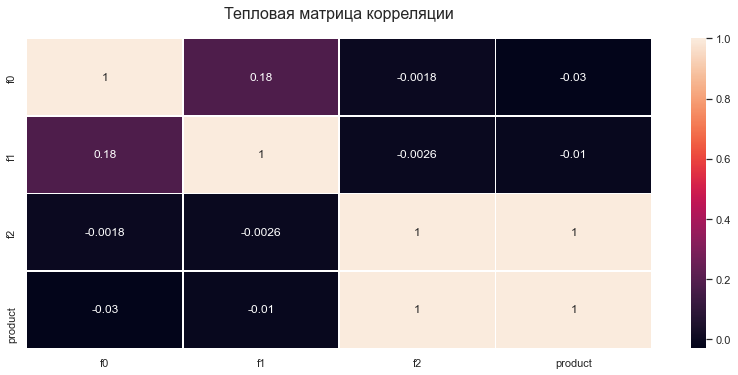

Количество дубликатов в таблице: 0
Количество дубликатов по скважинам: 4

Визуальная проверка дубликатов по столбцу "id"(первые 10 строк)


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305



Количество "пустых" скважин в регионе: 8235
Средний объем нефти в одной скважине: 68.83 тыс.баррелей


========================================[.....РЕГИОН №2.....]========================================

Первые 5 строк таблицы


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Основные статистические показатели


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Гистограммы и боксплоты по признакам


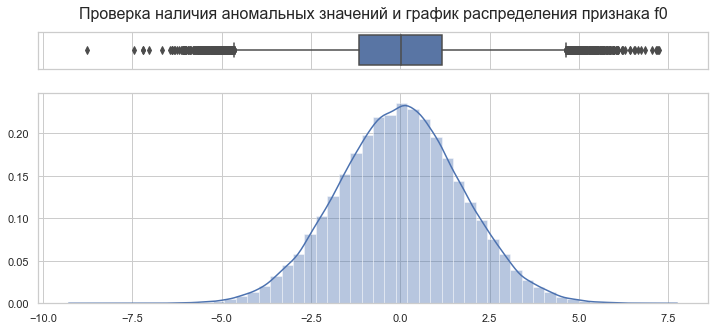

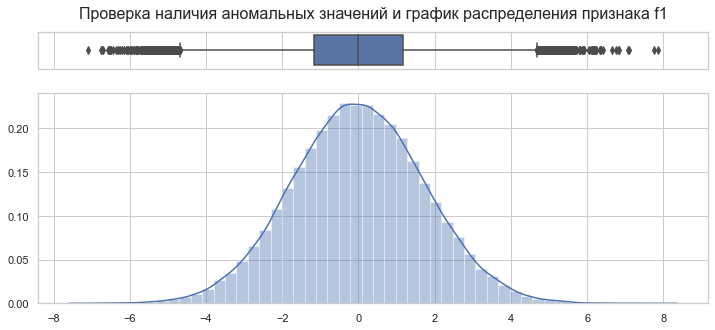

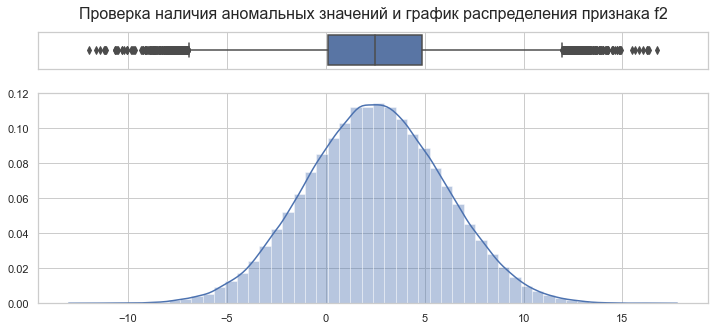

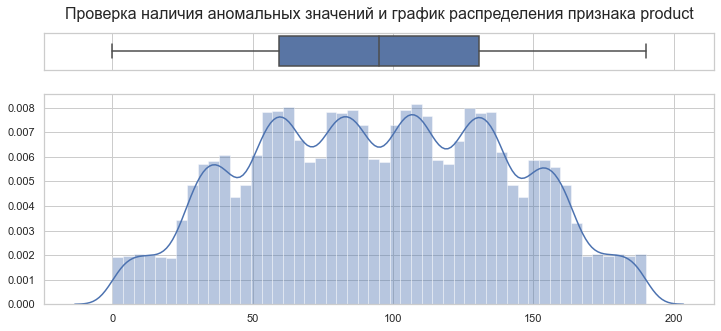


Проверка корреляции между признаками


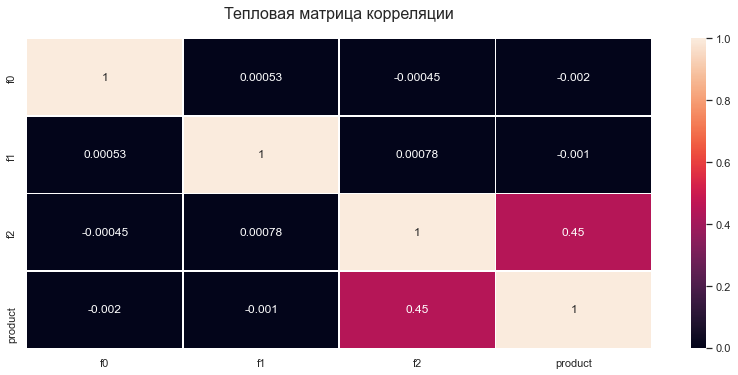

Количество дубликатов в таблице: 0
Количество дубликатов по скважинам: 4

Визуальная проверка дубликатов по столбцу "id"(первые 10 строк)


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641



Количество "пустых" скважин в регионе: 1
Средний объем нефти в одной скважине: 95.00 тыс.баррелей




In [4]:
my_info(data_0, 0)
my_info(data_1, 1)
my_info(data_2, 2)

Проверим уникальные значения целевого признака в регионе №1

In [5]:
display(data_1['product'].value_counts().sort_index())

0.000000      8235
3.179103      8337
26.953261     8468
30.132364     8306
53.906522     8472
57.085625     8390
80.859783     8320
84.038886     8431
107.813044    8201
110.992147    8303
134.766305    8304
137.945408    8233
Name: product, dtype: int64

**Вывод:**

- Во всех трех таблицах пропусков не обнаружено, наименования столбцов корректны, тип данных подходящий. Так же присутствует столбец "id", который не имеет ценности для обучения моделей, в дальнейшем при обучении моделей необходимо его не учитывать.
- Некоторые признаки во всех трех регионах имеют аномально высокие/низкие значения по сравнению с общей массой, но нам неизвестно что означают эти признаки, поэтому принимаю решение оставить их как есть.
- В регионе №0 обнаружена средняя корреляция между признаком f2 и целевым признаком, а так же обратная средняя корреляция между признаками f0 и f1. Корреляция не высокая, оставим все признаки для обучения моделей. По данному  региону не обнаружено полных дубликатов, но имеются 10 совпадений id скважин. Показатели признаков у этих скважин различны, не понятно какие из них правдивы, считаю необходимым полностью удалить из таблицы пары совпадений, так как их количество невелико. Также в регионе обнаружена одна пустая скважина. Данный регион занимает второе место по среднему объему запасов нефти в скважине - 92.50 тыс. баррелей.
- В регионе №2, также как и в регионе №0 обнаружена средняя корреляция между признаком f2 и целевым признаком, но полностью отсутствует корреляция между признаками f0 и f1. По данному  региону не обнаружено полных дубликатов, но имеются 4 совпадения id скважин. Показатели признаков у этих скважин различны, не понятно какие из них правдивы, считаю необходимым полностью удалить из таблицы пары совпадений, так как их количество невелико. Также в регионе обнаружена одна пустая скважина. Данный регион занимает первое место по среднему объему запасов нефти в скважине - 95.00 тыс. баррелей.
- Регион №1 сильно отличается от предыдущих регионов. Присутствует слабая корреляция между признаками f0 и f1, и максимально высокая корреляция между признаком f2 и целевым признаком, что очень странно (подозреваю что модель по данному региону будет предсказывать гораздо точнее из за такой корреляции). Кроме того в данном регионе есть сильное отличие признака f2 от других регионов, значения признака сильно похожи на дискретные, и это вероятно сильно влияет на целевой признак, так как его распределение так же не нормальное, а значения дискретны. Также в отличии от остальных регионов, в данном регионе очень большое количество "пустых" скважин, а именно 8235, что вероятно и ставит его на последнее место по среднему объему запасов нефти в скважине - 68.83 тыс. баррелей. По данному  региону не обнаружено полных дубликатов, но имеются 4 совпадения id скважин.

### Подготовка данных

Для начала полностью избавимся от дубликатов по id скважин

In [6]:
data_0 = data_0.drop_duplicates('id', keep=False).reset_index(drop=True)
data_1 = data_1.drop_duplicates('id', keep=False).reset_index(drop=True)
data_2 = data_2.drop_duplicates('id', keep=False).reset_index(drop=True)

Разделим данные на признаки и целевой признак

In [7]:
X_0 = data_0.drop(['product', 'id'], axis=1)
X_1 = data_1.drop(['product', 'id'], axis=1)
X_2 = data_2.drop(['product', 'id'], axis=1)
y_0 = data_0['product']
y_1 = data_1['product']
y_2 = data_2['product']

## Обучение и проверка модели

Для каждого региона разобьем данные на обучающую и валидационную выборки в соотношении 75:25, обучим модель и сделаем предсказания на валидационной выборке, сохраним предсказания и правильные ответы на валидационной выборке, выведем на экран средний запас предсказанного сырья, средний фактический запас сырья, RMSE модели и адекватность модели

In [8]:
model_0, predict_0, y_valid_0 = my_LinReg(X_0, y_0, 0)
model_1, predict_1, y_valid_1 = my_LinReg(X_1, y_1, 1)
model_2, predict_2, y_valid_2 = my_LinReg(X_2, y_2, 2)

========================================[.....РЕГИОН №0.....]========================================
Средний запас нефти в одной скважине по предсказанию модели: 92.39 тыс.баррелей
Средний фактический запас нефти в одной скважине : 92.50 тыс.баррелей
RMSE на валидационной выборке: 37.6763
Адекватность предсказаний модели: 15.0%

========================================[.....РЕГИОН №1.....]========================================
Средний запас нефти в одной скважине по предсказанию модели: 68.81 тыс.баррелей
Средний фактический запас нефти в одной скважине : 68.82 тыс.баррелей
RMSE на валидационной выборке: 0.8886
Адекватность предсказаний модели: 98.1%

========================================[.....РЕГИОН №2.....]========================================
Средний запас нефти в одной скважине по предсказанию модели: 94.91 тыс.баррелей
Средний фактический запас нефти в одной скважине : 95.00 тыс.баррелей
RMSE на валидационной выборке: 40.3047
Адекватность предсказаний модели: 10.5%



Для всех трех регионов модели на основе алгоритма Линейная регрессия в среднем предсказывают очень близкие к фактическим значениям средних запасов нефти в скважинах, но это не показатель работы моделей. RMSE моделей по региону №0 и №2 очень высокие, и даже если модели в итоге могут предсказать приближенный к истине общий объем нефти во всех скважинах, на каждой скважине они ошибаются в среднем на +/- 37.68 и +/- 40.30 тыс.баррелей соответственно, что на ряду с показателем адекватности моделей говорит о низкой вменяемости моделей по данным регионам. В регионе №1 ситуация обратная, RMSE модели очень низкий, а показатель адекватности близок к максимальному, что говорит о высоком качестве обученно модели для данного региона.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных

In [9]:
total_budget = 10**10                               # Бюджет на разработку скважин в регионе
price_per_barrel = 450                              # Доход с одного барреля сырья
price_unit_product = price_per_barrel*1000          # Доход с единицы продукта
max_prob_lose = 0.025                               # Максимальная вероятность убытков
borehole_count = 500                                # Количество точек для разведки
borehole_best = 200                                 # Количество лучших скважин для разработки

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [10]:
min_borehole_vol = total_budget /(borehole_best * price_unit_product)
print('Минимальный объём сырья для безубыточной разработки новой скважины:',\
      f'{min_borehole_vol:.2f} тыс. баррелей')

Минимальный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


Для региона №0 в среднем для безубыточной разработки новой скважины нехватка составляет 16.75% от необходимого объема, для региона №1 - 38.06%, для региона №2 - 14.5%. Но стоит отметить что в регионе №1 более 8% пустых скважин, что приводит к низкому показателю среднего объема нефти в скважине по региону.

Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели подготовлена в начале проекта

## Расчёт прибыли и рисков 

Для каждого региона применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Выведем среднюю прибыль, 95%-й доверительный интервал и риск убытков

========================================[.....РЕГИОН №0.....]========================================



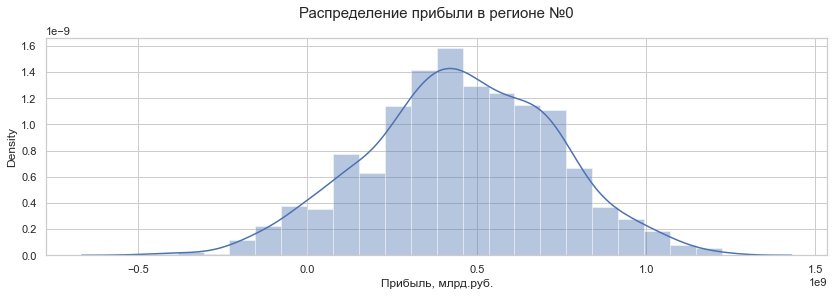


Средняя прибыль: 455.54 млн.рублей
95%-й доверительный интервал: от -105.44 до 990.01 млн.рублей
Риск убытков: 5.90%


========================================[.....РЕГИОН №1.....]========================================



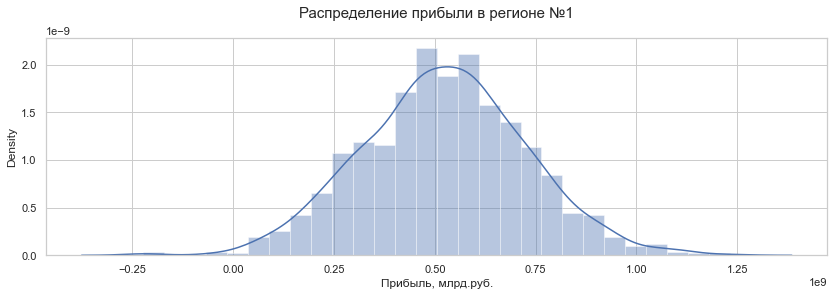


Средняя прибыль: 523.28 млн.рублей
95%-й доверительный интервал: от 125.93 до 919.36 млн.рублей
Риск убытков: 0.40%


========================================[.....РЕГИОН №2.....]========================================



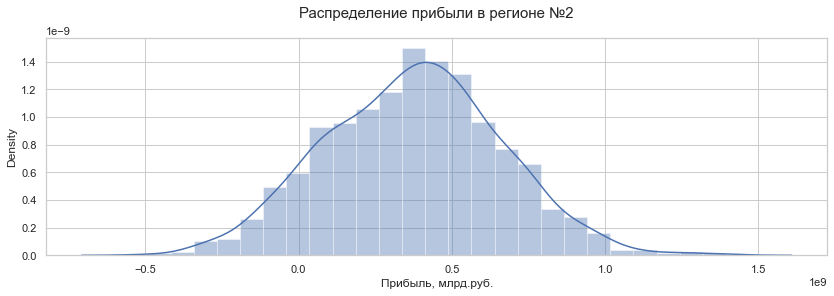


Средняя прибыль: 373.78 млн.рублей
95%-й доверительный интервал: от -159.12 до 929.74 млн.рублей
Риск убытков: 9.90%




In [11]:
my_Bootstrap(y_valid_0, predict_0, 0)
my_Bootstrap(y_valid_1, predict_1, 1)
my_Bootstrap(y_valid_2, predict_2, 2)

## Вывод

В начале подготовки проекта мы изучили информацию о данных по трем регионам, ознакомились с основными статистическими показателями, убедились в отсутствии пропусков, изучили распределения признаков и наличие аномальных значений в них, а так же проверили отсутствие значимой корреляции между признаками. 

Краткие результаты проверки данных:
- Во всех трех регионах при изучении распределения признаков выявлены выбивающиеся значения.
- В регионах №0 и №2 обнаружена прямая средняя корреляция между признаком f2 и целевым признаком, но в регионе №1 корреляция максимальная и принимает значение равное 1.
- Распределения признаков во всех трех регионах визуально различны. Распределения целевых признаков у регионов №0 и №2 схожи, в то время как в регионе №1 оно сильно отличается и похоже на распределение дискретных периодичных значений, что подтверждается проверкой уникальных значений объемов запаса сырья в 100000 скважинах - их всего 12.
- Во всех трех регионах обнаружены дубликаты id скважин с различными значениями признаков. Их количество мизерно, было принято решение избавиться от них.
- В регионе №0 и №2 обнаружено по одной пустой скважине, в то время как в регионе №1 их более 8%.

Далее для каждого региона мы разбили данные на признаки и целевой признак, разделили на обучающую и валидационную выборки, обучили модель, проверили ее на валидационной выборке и получили следующие результаты:

- Модели в регионах №0 и №2 предсказали близкий к фактическому среднему запас нефти в одной скважине, но RMSE данных моделей оставляет желать лучшего : 37.68 и 40.30. Также обе модели не прошли проверку на адекватность, их качество не сильно отличается от модели, которая бы всегда предсказывала среднее.
- Модель в регионе №1 показала себя наилучшим образом. У нее очень низкий показатель RMSE - 0.89, и она на отлично прошла проверку на вменяемость.

Мы расчитали минимальный объем сырья для безубыточной разработки новой скважины - 111, 12 тыс.баррелей. Для региона №0 в среднем для безубыточной разработки новой скважины нехватка составляет 16.75% от необходимого объема, для региона №1 - 38.06%, для региона №2 - 14.5%. Но стоит отметить что в регионе №1 более 8% пустых скважин, что приводит к низкому показателю среднего объема нефти в скважине по региону.

Для определения распределения прибыли для каждого региона мы применили технику Bootstrap c 1000 выборок, по результатам которой определили для региона №0 и №2 среднюю прибыль, которая оказалась ниже чем в регионе №1. Кроме того 95%-й доверительный интервал прибыли для обоих регионов начинается с отрицательного значения, что подкрепляется высоким риском убытков - более 4%. 

Регион №1 можно считать лучшим по показателю средней прибыли, кроме того риск получения убытков в нем менее 1.5%. Для принятия окончательного решения по разработке скважин в регионе №1 необходимо получить подтверждение корректности данных по региону, так как она вызывает сомнения в связи с многократным повторением одинаковых значений объема запаса нефти в различных скважинах и максимально высокой корреляцией между признаком f2 и целевым признаком.